In [1]:
import cv2
import itertools
import numpy as np
from scipy import linalg
import matplotlib as mpl
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Ellipse
from eye_gaze_data_reader import get_eye_gaze_data

In [57]:
image_path = './images/Picnic_segmentation.png'
image = cv2.imread(image_path)

# Convert the image to RGB (OpenCV loads images in BGR format by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape(-1, 3)

# Use a KD-Tree to find unique colors within a threshold
threshold = 5
tree = cKDTree(pixels)
unique_colors = []
labels = np.zeros(pixels.shape[0], dtype=int) - 1

for i, pixel in enumerate(pixels):
    if labels[i] == -1:
        indices = tree.query_ball_point(pixel, threshold)
        unique_colors.append(pixel)
        labels[indices] = len(unique_colors) - 1

unique_colors = np.array(unique_colors)

# Print unique colors
print(f"Unique colors (within threshold): {unique_colors}")

Unique colors (within threshold): [[  0   0   0]
 [  0   0 255]
 [255   0   0]
 [  0 255   0]
 [128   0   0]
 [  0   0 128]
 [255   0 128]
 [  0 128 255]
 [128   0 255]
 [  0 128   0]
 [255 128   0]
 [  0 255 128]
 [128 255   0]
 [128 255 128]
 [128 128 128]
 [255 128 128]
 [128 128 255]]


In [58]:
# Create a dictionary mapping from color tuples to segment labels
color_to_label = {tuple(color): label for label, color in enumerate(unique_colors)}

# Print the mapping
print(f"Color to label mapping: {color_to_label}")


Color to label mapping: {(0, 0, 0): 0, (0, 0, 255): 1, (255, 0, 0): 2, (0, 255, 0): 3, (128, 0, 0): 4, (0, 0, 128): 5, (255, 0, 128): 6, (0, 128, 255): 7, (128, 0, 255): 8, (0, 128, 0): 9, (255, 128, 0): 10, (0, 255, 128): 11, (128, 255, 0): 12, (128, 255, 128): 13, (128, 128, 128): 14, (255, 128, 128): 15, (128, 128, 255): 16}


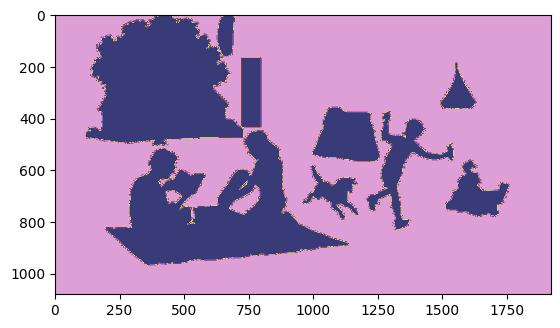

0


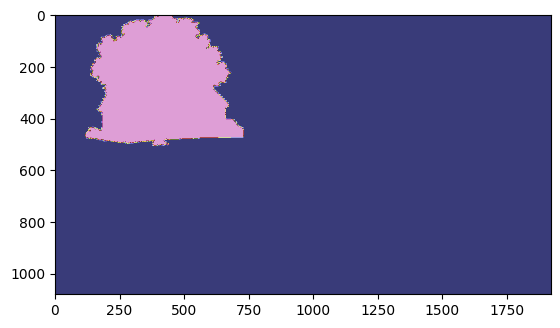

1


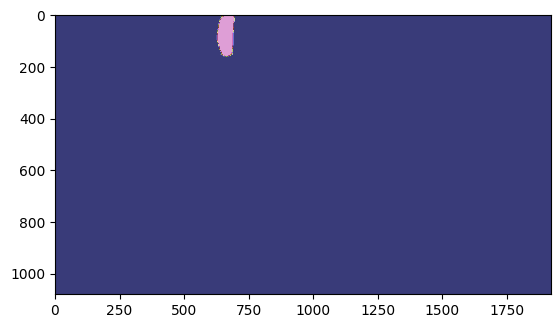

2


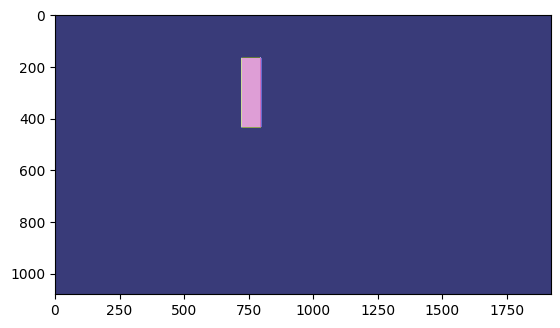

3


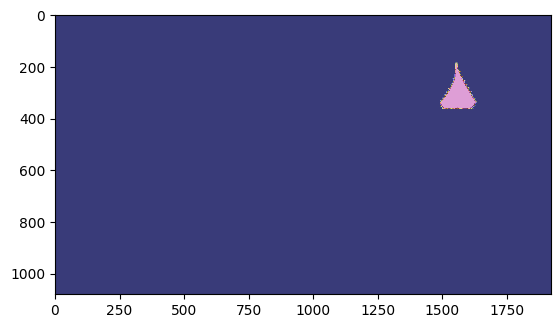

4


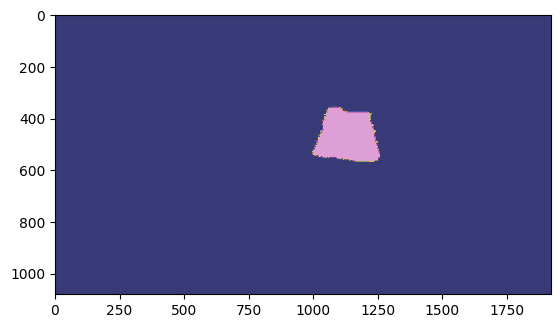

5


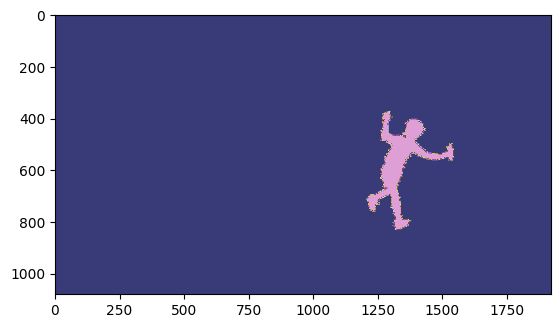

6


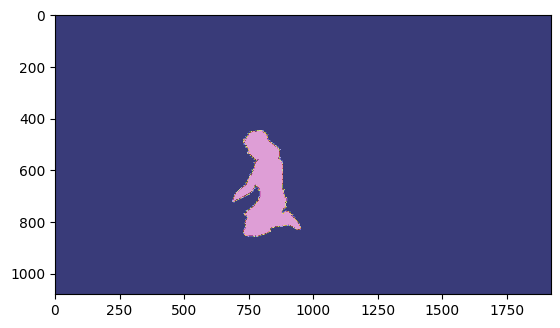

7


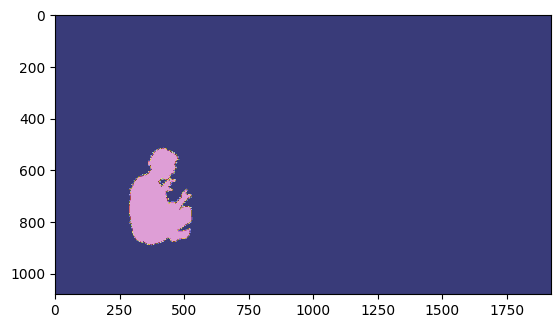

8


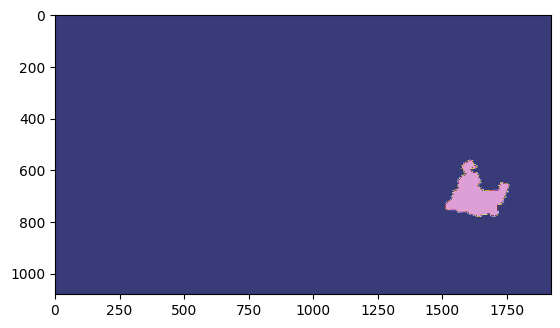

9


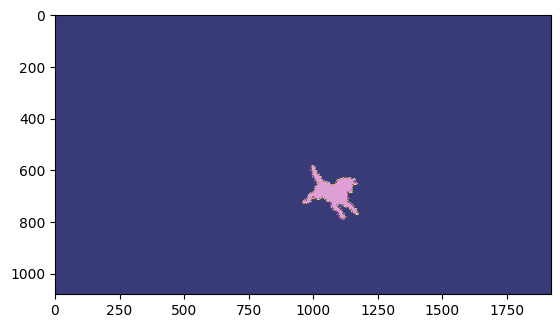

10


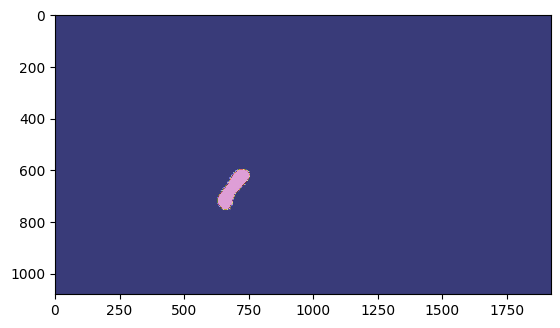

11


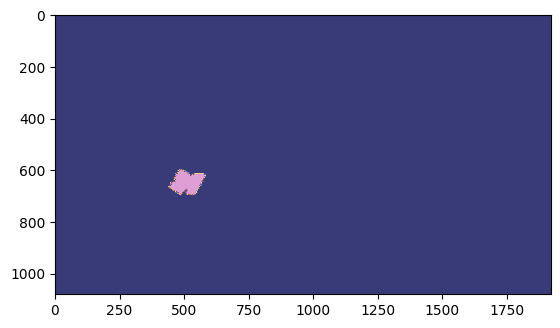

12


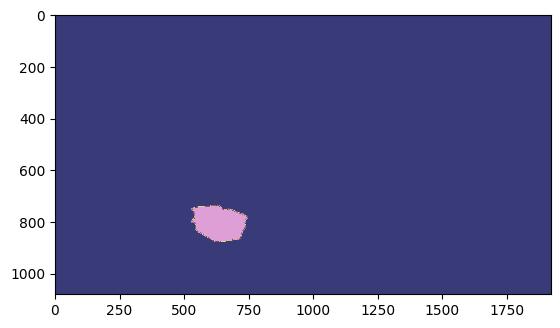

13


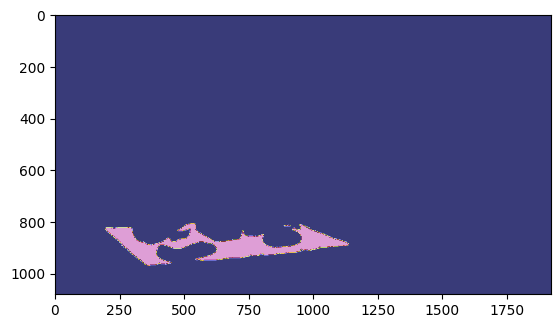

14


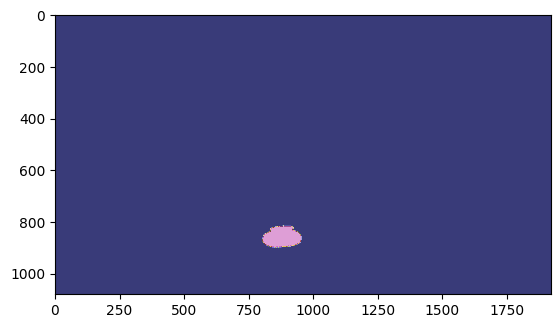

15


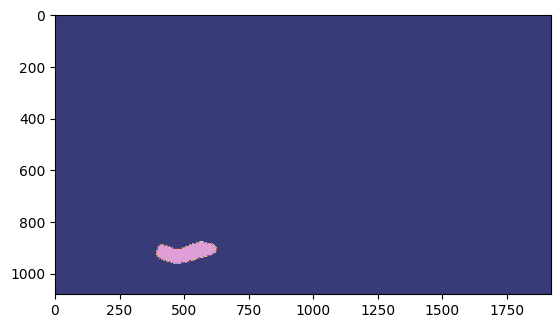

16
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [59]:
# Initialize the segmented mask with the same height and width as the input image
segmented_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.int32)

# Assign labels to each pixel based on the color
for i, color in enumerate(unique_colors):
    mask = np.all(image_rgb==color, axis=-1)
    plt.imshow(mask, cmap='tab20b')
    plt.show()
    print(i)
    segmented_mask[mask] = i

# Print the segmented mask
print(segmented_mask)


(959, 539, (0, 0, 0))
(1261, 842, (128, 0, 0))
(1259, 422, (255, 255, 0))
(1098, 562, (255, 255, 0))
(673, 394, (0, 255, 255))
(434, 654, (255, 0, 255))
(1435, 408, (0, 0, 128))
(594, 786, (0, 255, 0))
(1638, 715, (0, 128, 0))
(1527, 705, (0, 128, 0))
[(959, 539, (0, 0, 0)), (1261, 842, (128, 0, 0)), (1259, 422, (255, 255, 0)), (1098, 562, (255, 255, 0)), (673, 394, (0, 255, 255)), (434, 654, (255, 0, 255)), (1435, 408, (0, 0, 128)), (594, 786, (0, 255, 0)), (1638, 715, (0, 128, 0)), (1527, 705, (0, 128, 0))]
Centroid of color (0, 0, 0): (959, 539)
Centroid of color (128, 0, 0): (1261, 842)
Centroid of color (255, 255, 0): (1259, 422)
Centroid of color (255, 255, 0): (1098, 562)
Centroid of color (0, 255, 255): (673, 394)
Centroid of color (255, 0, 255): (434, 654)
Centroid of color (0, 0, 128): (1435, 408)
Centroid of color (0, 255, 0): (594, 786)
Centroid of color (0, 128, 0): (1638, 715)
Centroid of color (0, 128, 0): (1527, 705)
959 539 (0, 0, 0)
1261 842 (128, 0, 0)
1178 492 (255,

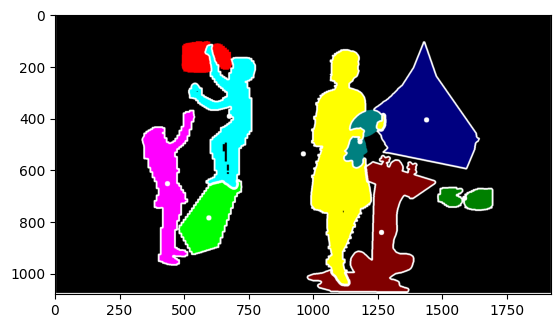

In [5]:
centroids = []
# Iterate over each unique color
for color in unique_colors:
    # Create a mask for the current color
    mask = cv2.inRange(image, color, color)
    
    # Find the contours of the masked region
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (255,255,255), 5)
    # Compute the centroid of each contour
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY, tuple(color)))
        else:
            centroids.append((0, 0, tuple(color)))
        print(centroids[-1])

print(centroids)
post_processed_centroids = {}
# Print the centroids
for idx, (cX, cY, color) in enumerate(centroids):
    print(f"Centroid of color {color}: ({cX}, {cY})")
    if post_processed_centroids.get(color) is not None:
        post_processed_centroids[color][0] += cX
        post_processed_centroids[color][1] += cY
        post_processed_centroids[color][0] /= 2
        post_processed_centroids[color][1] /= 2
        post_processed_centroids[color][0] = round(post_processed_centroids[color][0])
        post_processed_centroids[color][1] = round(post_processed_centroids[color][1])
    else:
        post_processed_centroids[color] = [cX, cY]

centroids = []
for color in list(post_processed_centroids.keys()):
    centroids.append((post_processed_centroids[color][0], post_processed_centroids[color][1], color))


# Optionally, draw the centroids on the image for visualization
for (cX, cY, color) in centroids:
    print(cX, cY, color)
    cv2.circle(image, (cX, cY), 10, (255, 255, 255), -1)

plt.imshow(image)
plt.show()

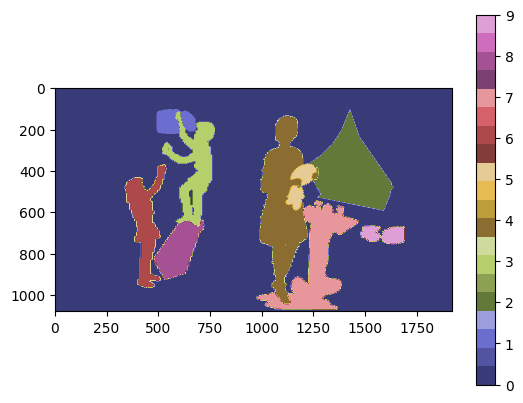

In [6]:
import matplotlib.pyplot as plt

plt.imshow(segmented_mask, cmap='tab20b')
plt.colorbar()
plt.show()


In [7]:
mask_id_list = np.unique(segmented_mask)
mask_id_list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
# image_component_id_lookup = {
#     0: "Surrounding",
#     1: "Cookie Jar",
#     2: "Window",
#     3: "Boy",
#     4: "Lady's Head",
#     5: "Cookie"
#     6: "Lady's Body",
#     7: "Plate",
#     8: "Girl",
#     9: "Washing Cloth",
#     10: "Sink",
#     11: "Stool",
#     12: "Water",
#     13: "Dishes",
#     14: "Image Components"
# }
# seperated_masks = {}
image_component_id_lookup = {
    0: "Surrounding",
    1: "Cookie Jar",
    2: "Window",
    3: "Boy",
    4: "Lady",
    5: "Plate, Washing Cloth",
    6: "Girl",
    7: "Sink, Water",
    8: "Stool",
    9: "Dishes",
    10: "Image Components"
}
seperated_masks = {}

In [9]:
for id in mask_id_list:
    isolated_mask = segmented_mask.copy()
    isolated_mask[isolated_mask != id] = -1
    print(f"id: {id}, tag: {image_component_id_lookup[id]}")
    print(np.unique(isolated_mask))
    seperated_masks[id] = isolated_mask
    # plt.imshow(seperated_masks[id], cmap='nipy_spectral')
    # plt.colorbar()
    # plt.show()

id: 0, tag: Surrounding
[-1  0]
id: 1, tag: Cookie Jar
[-1  1]
id: 2, tag: Window
[-1  2]
id: 3, tag: Boy
[-1  3]
id: 4, tag: Lady
[-1  4]
id: 5, tag: Plate, Washing Cloth
[-1  5]
id: 6, tag: Girl
[-1  6]
id: 7, tag: Sink, Water
[-1  7]
id: 8, tag: Stool
[-1  8]
id: 9, tag: Dishes
[-1  9]


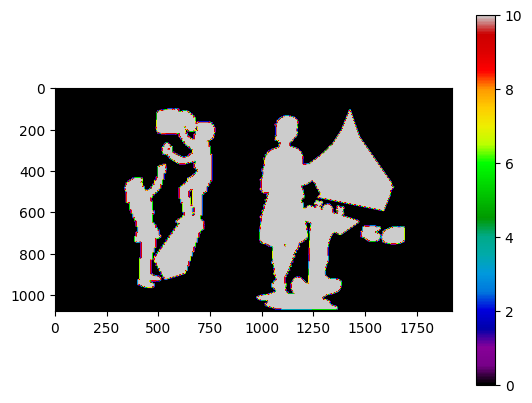

In [10]:
image_component_mask = segmented_mask.copy()
image_component_mask[image_component_mask != 0] = len(image_component_id_lookup) - 1
seperated_masks[len(image_component_id_lookup) - 1] = image_component_mask 
plt.imshow(seperated_masks[len(image_component_id_lookup) - 1], cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [11]:
def get_pixel_coordinates(segmented_mask, label):
    # print(np.column_stack(np.where(segmented_mask == label)))
    image_component_mask = segmented_mask.copy()
    image_component_mask[image_component_mask != label] = -1
    # plt.imshow(image_component_mask, cmap='nipy_spectral')
    print(np.unique(segmented_mask))
    print(np.unique(image_component_mask))
    # plt.show()
    return np.column_stack(np.where(segmented_mask == label))

def fit_gmm_to_component(coordinates, n_components):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(coordinates)
    return gmm

def compute_likelihoods(gmm, coordinates):
    return gmm.score_samples(coordinates)

In [12]:
param_grid = {
    'n_components': range(1, 2),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    # 'reg_covar': [1e-6, 1e-4, 1e-2, 1e-1]
}
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)
hyperparameters = {}
for key in list(image_component_id_lookup.keys()):
    if key == 0:
        continue
    print(f"Searching: {key} - {image_component_id_lookup[key]}")
    # Define the GMM model
    gmm = GaussianMixture(random_state=0)
    grid_search = GridSearchCV(
        gmm, param_grid=param_grid, scoring=gmm_bic_score
    )
    # Perform GridSearchCV
    component_coords = get_pixel_coordinates(seperated_masks[key], key)
    grid_search.fit(component_coords)

    # Best parameters
    best_params = grid_search.best_params_
    hyperparameters[key] = best_params

    print(f'Best parameters: {best_params}')

Searching: 1 - Cookie Jar
[-1  1]
[-1  1]
Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 2 - Window
[-1  2]
[-1  2]
Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 3 - Boy
[-1  3]
[-1  3]
Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 4 - Lady
[-1  4]
[-1  4]
Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 5 - Plate, Washing Cloth
[-1  5]
[-1  5]
Best parameters: {'covariance_type': 'full', 'n_components': 1}
Searching: 6 - Girl
[-1  6]
[-1  6]
Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 7 - Sink, Water
[-1  7]
[-1  7]
Best parameters: {'covariance_type': 'tied', 'n_components': 1}
Searching: 8 - Stool
[-1  8]
[-1  8]
Best parameters: {'covariance_type': 'full', 'n_components': 1}
Searching: 9 - Dishes
[-1  9]
[-1  9]
Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 10 - Image Components
[ 0 10]
[-1 10]
Bes

In [13]:
component_gmms = {}
gmm_means = []
gmm_covariances = []
gmm_weights = []
for key in list(image_component_id_lookup.keys()):
    if key == 0 or key == len(image_component_id_lookup) - 1:
        continue
    print(f"Fitting: {key} - {image_component_id_lookup[key]}")
    component_coords = get_pixel_coordinates(seperated_masks[key], key)
    component_coords[:, [0, 1]] = component_coords[:, [1, 0]]
    print(f"data: {component_coords}")
    gmm = fit_gmm_to_component(component_coords, hyperparameters[key]["n_components"])
    gmm_means.append(gmm.means_)
    gmm_covariances.append(gmm.covariances_)
    gmm_weights.append(gmm.weights_)
    component_gmms[image_component_id_lookup[key]] = gmm

Fitting: 1 - Cookie Jar
[-1  1]
[-1  1]
data: [[584 104]
 [585 104]
 [586 104]
 ...
 [581 226]
 [582 226]
 [583 226]]
Fitting: 2 - Window
[-1  2]
[-1  2]
data: [[1424  108]
 [1425  108]
 [1426  108]
 ...
 [1587  596]
 [1588  596]
 [1589  596]]
Fitting: 3 - Boy
[-1  3]
[-1  3]
data: [[599 118]
 [600 118]
 [601 118]
 ...
 [694 670]
 [695 670]
 [696 670]]
Fitting: 4 - Lady
[-1  4]
[-1  4]
data: [[1112  138]
 [1113  138]
 [1114  138]
 ...
 [1130 1046]
 [1131 1046]
 [1132 1046]]
Fitting: 5 - Plate, Washing Cloth
[-1  5]
[-1  5]
data: [[1223  369]
 [1224  369]
 [1225  369]
 ...
 [1165  592]
 [1166  592]
 [1167  592]]
Fitting: 6 - Girl
[-1  6]
[-1  6]
data: [[520 372]
 [521 372]
 [522 372]
 ...
 [469 967]
 [470 967]
 [471 967]]
Fitting: 7 - Sink, Water
[-1  7]
[-1  7]
data: [[1264  546]
 [1265  546]
 [1266  546]
 ...
 [1359 1072]
 [1360 1072]
 [1361 1072]]
Fitting: 8 - Stool
[-1  8]
[-1  8]
data: [[703 640]
 [704 640]
 [705 640]
 ...
 [541 926]
 [542 926]
 [543 926]]
Fitting: 9 - Dishes
[-1  

In [14]:
combined_means = np.vstack(gmm_means)
combined_covariances = np.vstack(gmm_covariances)
combined_weights = np.hstack(gmm_weights)
combined_weights /= np.sum(combined_weights)

combined_gmm = GaussianMixture(n_components=len(combined_means), covariance_type='full')
combined_gmm.means_ = combined_means
combined_gmm.covariances_ = combined_covariances
combined_gmm.weights_ = combined_weights
combined_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(combined_covariances)).transpose((0, 2, 1))

component_gmms[len(image_component_id_lookup) - 1] = combined_gmm

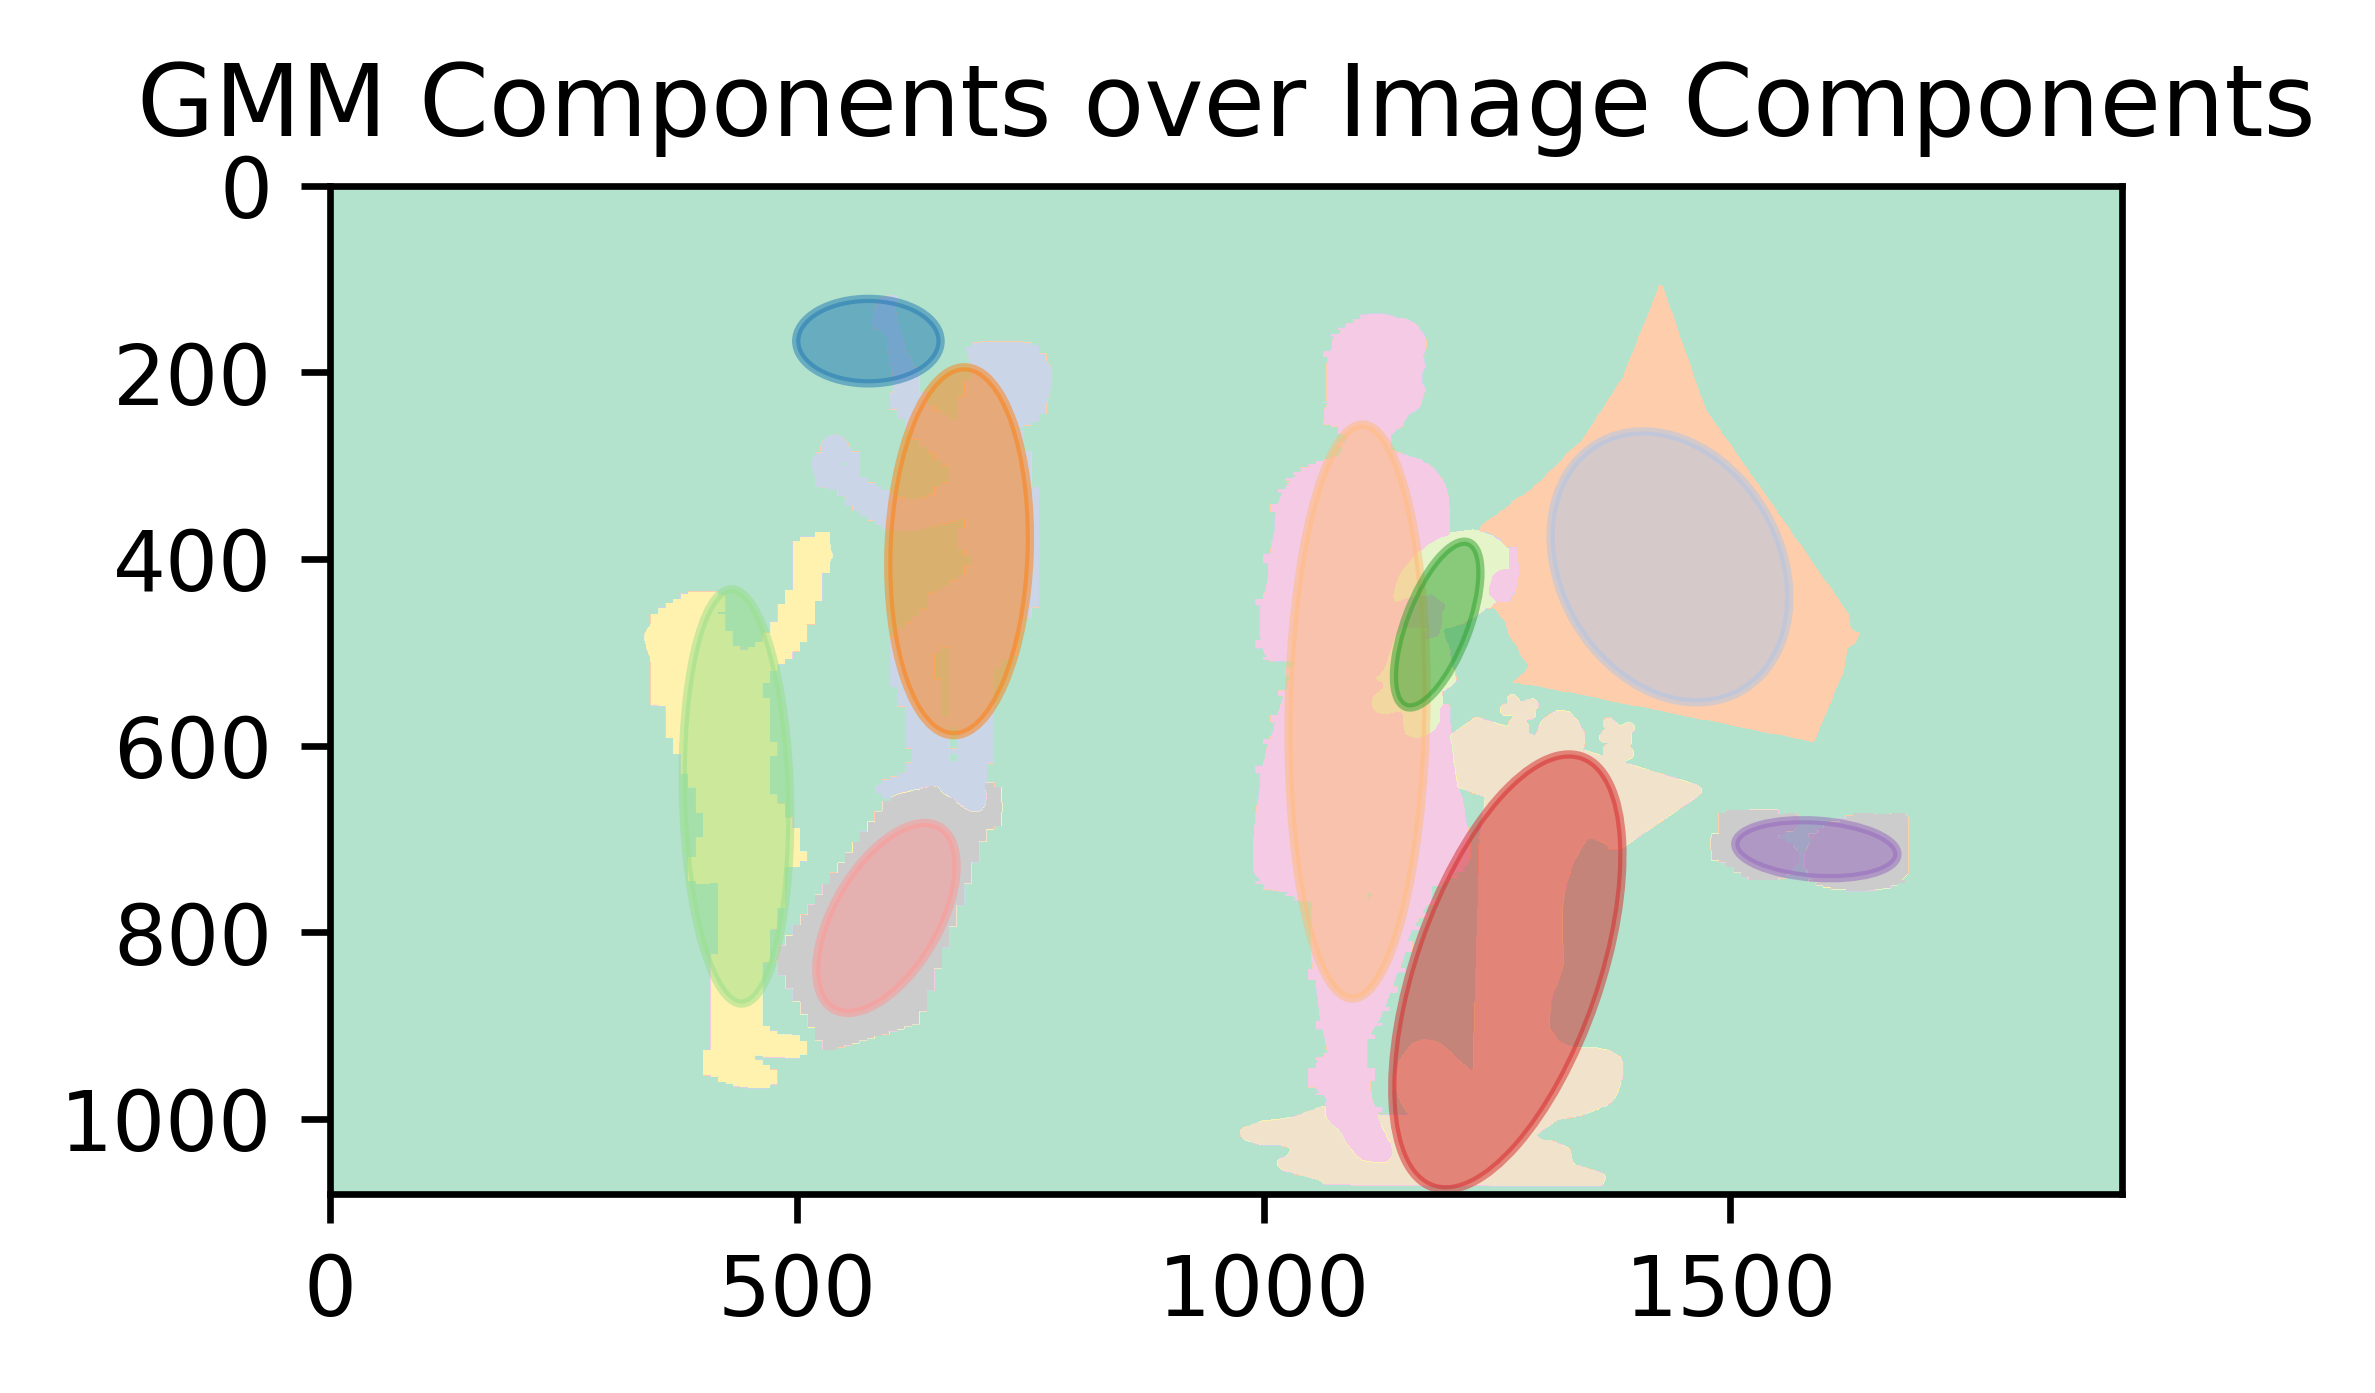

In [55]:
# color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_gmm(X, Y_, means, covariances, index, title, width, height):
    plt.figure(dpi=600)
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar) in enumerate(zip(means, covariances)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not (X is None or Y_ is None):
            if not np.any(Y_ == i):
                continue
            plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=plt.cm.tab20(i))
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    splot.set_aspect('equal', 'box')
    # splot.invert_yaxis()
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().invert_yaxis()
    # plt.xticks(())
    # plt.yticks(())
    plt.title(title)
    plt.imshow(segmented_mask, cmap='Pastel2', alpha=1)

# Plot the combined GMM

x_max = 1920
y_max = 1080
# print(combined_gmm.means_)
# print(combined_gmm.covariances_)

plot_gmm(None, None, combined_gmm.means_, combined_gmm.covariances_, 0, 'GMM Components over Image Components', x_max, y_max)


In [30]:
def get_normalized_log_likelihood(filepath, x_scale, y_scale, gmm, show_plot=True):
    points, _ = get_eye_gaze_data(filepath)
    points[:, 0] *= x_scale
    points[:, 1] *= y_scale
    log_llh = combined_gmm.score(points)
    # log_llh /= points.shape[0]
    if show_plot:
        plt.scatter(points[:, 0], points[:, 1], marker='x', s=1)
        plt.show()
    return log_llh

P02


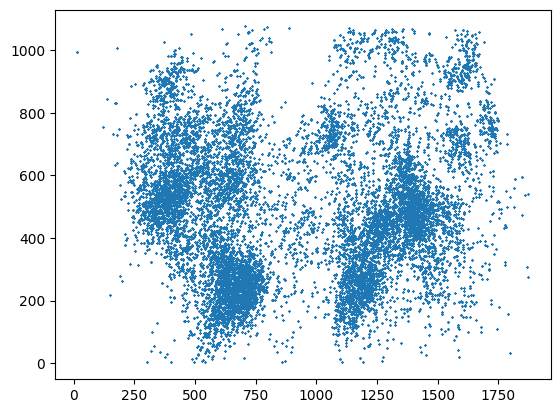

S1: -14.854097054495151


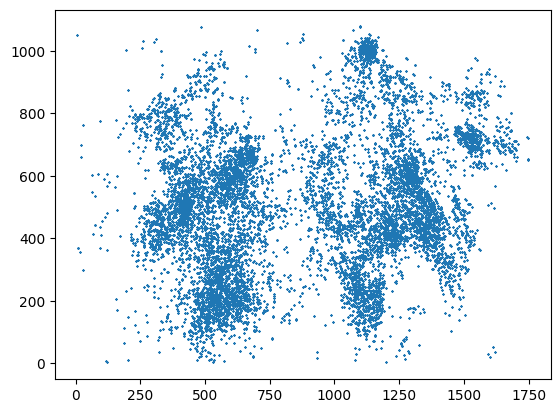

S3: -14.808246248785958


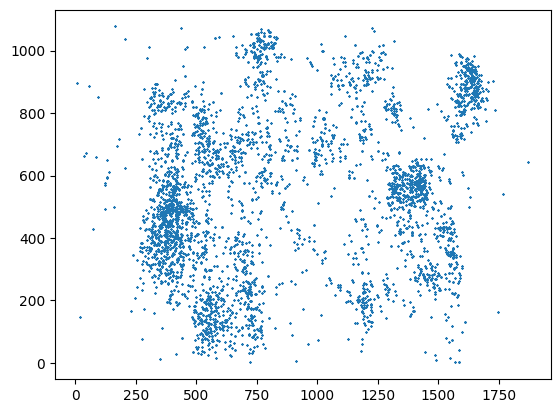

S5: -16.128021822543648


In [31]:
print("P02")
print("S1:", get_normalized_log_likelihood("data/P02_S1_all_gaze.csv", x_max, y_max, combined_gmm))
print("S3:", get_normalized_log_likelihood("data/P02_S3_all_gaze.csv", x_max, y_max, combined_gmm))
print("S5:", get_normalized_log_likelihood("data/P02_S5 # Partial_all_gaze.csv", x_max, y_max, combined_gmm))
print("====================")
# print("S2:", get_normalized_log_likelihood("data/P02_S2_all_gaze.csv", x_max, y_max, combined_gmm))
# print("S4:", get_normalized_log_likelihood("data/P02_S4_all_gaze.csv", x_max, y_max, combined_gmm))

P07


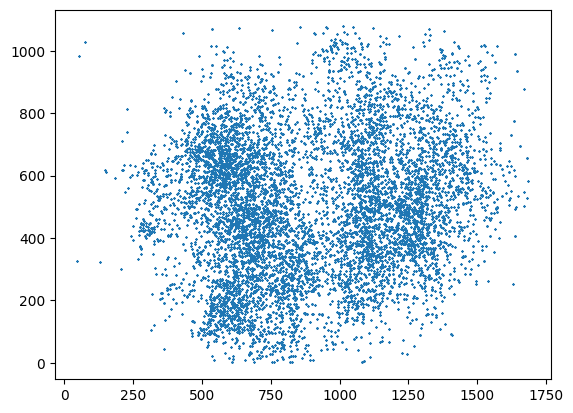

S1: -14.953958288883811


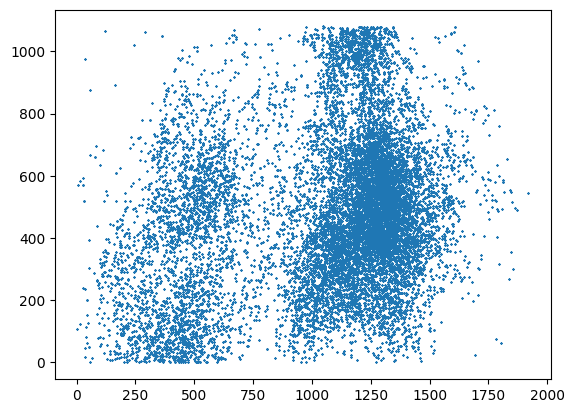

S3: -15.57358015314518


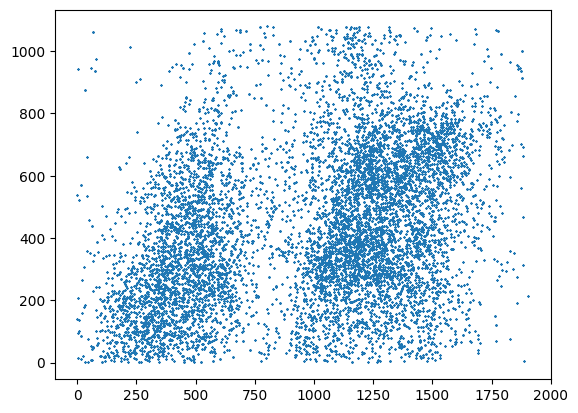

S5: -16.64003309211906


In [32]:
print("P07")
print("S1:", get_normalized_log_likelihood("data/P07_S1_all_gaze.csv", x_max, y_max, combined_gmm))
print("S3:", get_normalized_log_likelihood("data/P07_S3_all_gaze.csv", x_max, y_max, combined_gmm))
print("S5:", get_normalized_log_likelihood("data/P07_S5_all_gaze.csv", x_max, y_max, combined_gmm))
print("====================")
# print("S2:", get_normalized_log_likelihood("data/P07_S2_all_gaze.csv", x_max, y_max, combined_gmm))
# print("S4:", get_normalized_log_likelihood("data/P07_S4_all_gaze.csv", x_max, y_max, combined_gmm))

P23


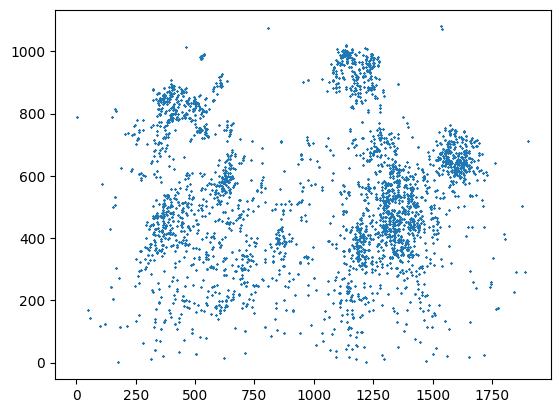

S1: -14.941040219256598


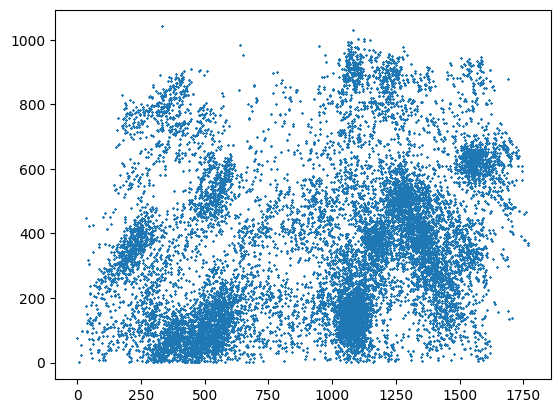

S3: -16.768174958272045


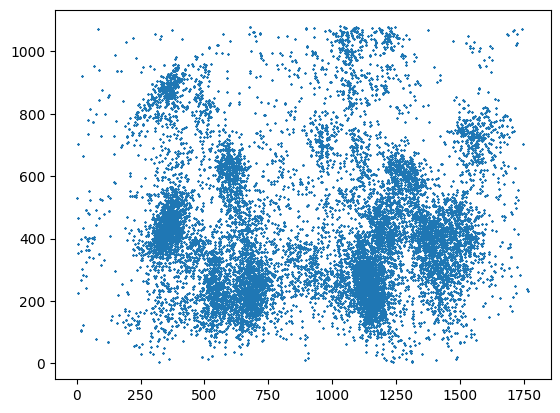

S5: -15.23663132888791


In [33]:
print("P23")
print("S1:", get_normalized_log_likelihood("data/P23_S1_all_gaze.csv", x_max, y_max, combined_gmm))
print("S3:", get_normalized_log_likelihood("data/P23_S3_all_gaze.csv", x_max, y_max, combined_gmm))
print("S5:", get_normalized_log_likelihood("data/P23_S5_all_gaze.csv", x_max, y_max, combined_gmm))
print("====================")
# print("S2:", get_normalized_log_likelihood("data/P23_S2_all_gaze.csv", x_max, y_max, combined_gmm))
# print("S4:", get_normalized_log_likelihood("data/P23_S4_all_gaze.csv", x_max, y_max, combined_gmm))

In [34]:
# points = get_eye_gaze_data("data/P23_S1_all_gaze.csv")

# points[:, 0] *= x_max
# points[:, 1] *= y_max
# eye_gaze_gmm = fit_gmm_to_component(points, 10)

# plot_gmm(None, None, eye_gaze_gmm.means_, eye_gaze_gmm.covariances_, 0, 'Eye Gaze Data GMM', x_max, y_max)

In [52]:
param_grid_eye_gaze = {
    'n_components': [1, 3, 5, 7, 9, 11],
    'covariance_type': ['full'],
    # 'reg_covar': [1e-6, 1e-4, 1e-2, 1e-1]
}

def search_parameter_eye_gaze(filepath, param_grid, scoring, x_scale=1920, y_scale=1080):    
    # Define the GMM model
    gmm = GaussianMixture(random_state=0)
    
    grid_search = GridSearchCV(
        gmm, param_grid=param_grid, scoring=scoring
    )
    # Perform GridSearchCV
    points = get_eye_gaze_data(filepath)
    points[:, 0] *= x_scale
    points[:, 1] *= y_scale
    
    grid_search.fit(points)
    
    # Best parameters
    best_params = grid_search.best_params_
    eye_gaze_gmm = fit_gmm_to_component(points, best_params["n_components"])
    
    plot_gmm(None, None, eye_gaze_gmm.means_, eye_gaze_gmm.covariances_, 0, 'Eye Gaze Data GMM', x_scale, y_scale)
    print(f'Best parameters: {best_params}')
    return best_params


Best parameters: {'covariance_type': 'full', 'n_components': 3}
Best parameters: {'covariance_type': 'full', 'n_components': 3}


C:\Users\zhoux\anaconda3\envs\HRI\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(
C:\Users\zhoux\anaconda3\envs\HRI\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(
C:\Users\zhoux\anaconda3\envs\HRI\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(
C:\Users\zhoux\anaconda3\envs\HRI\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans i

Best parameters: {'covariance_type': 'full', 'n_components': 3}


{'covariance_type': 'full', 'n_components': 3}

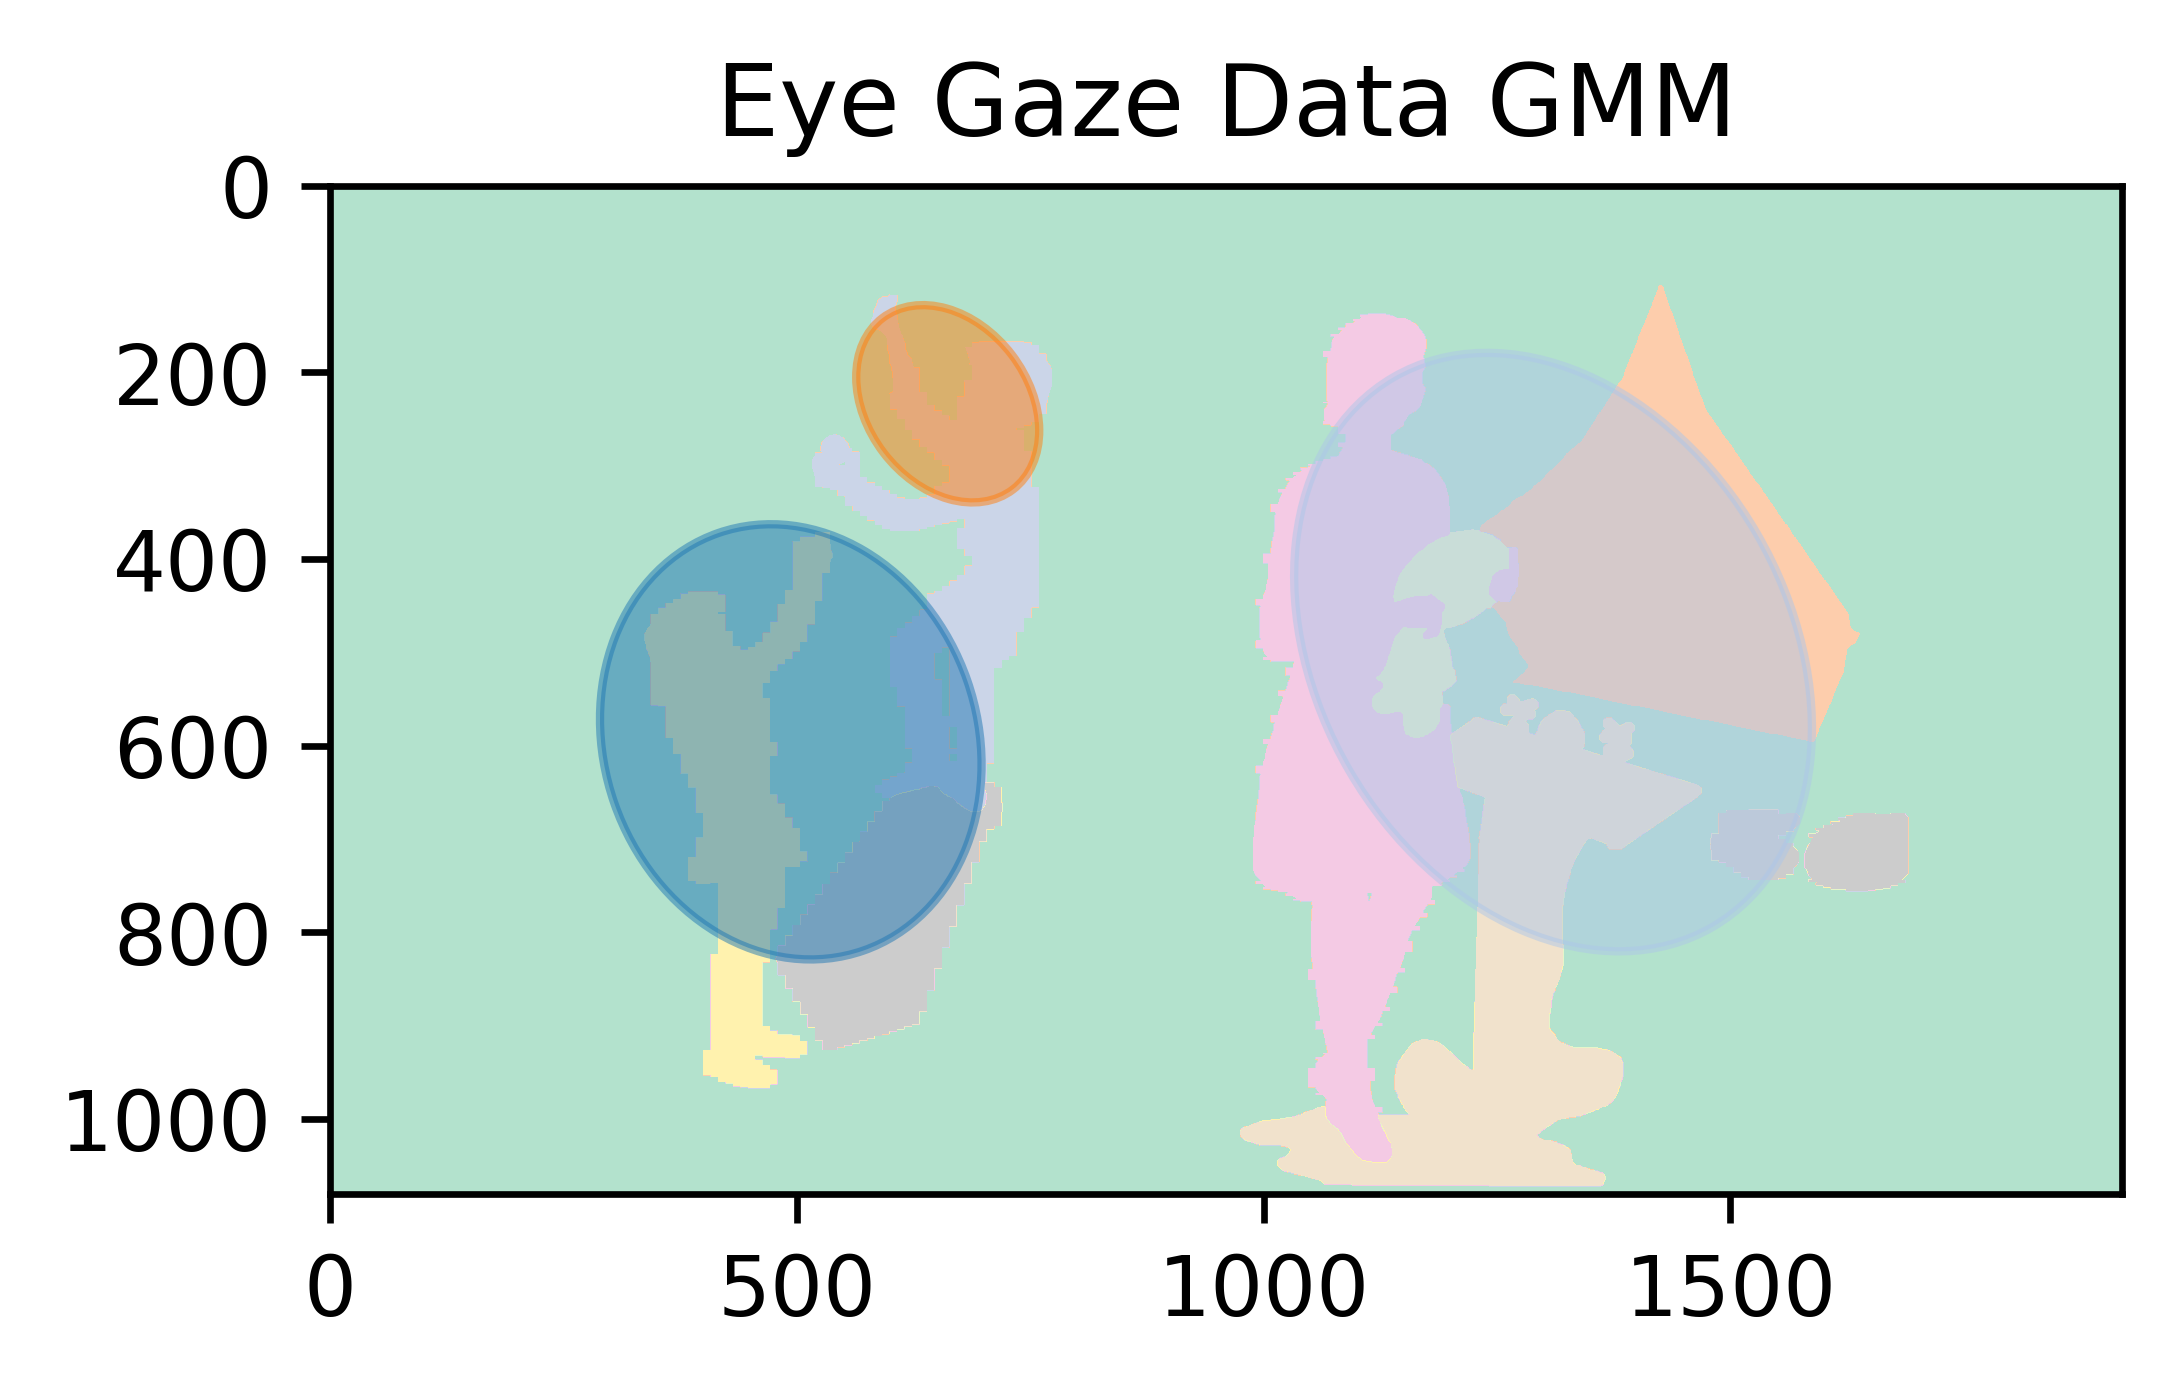

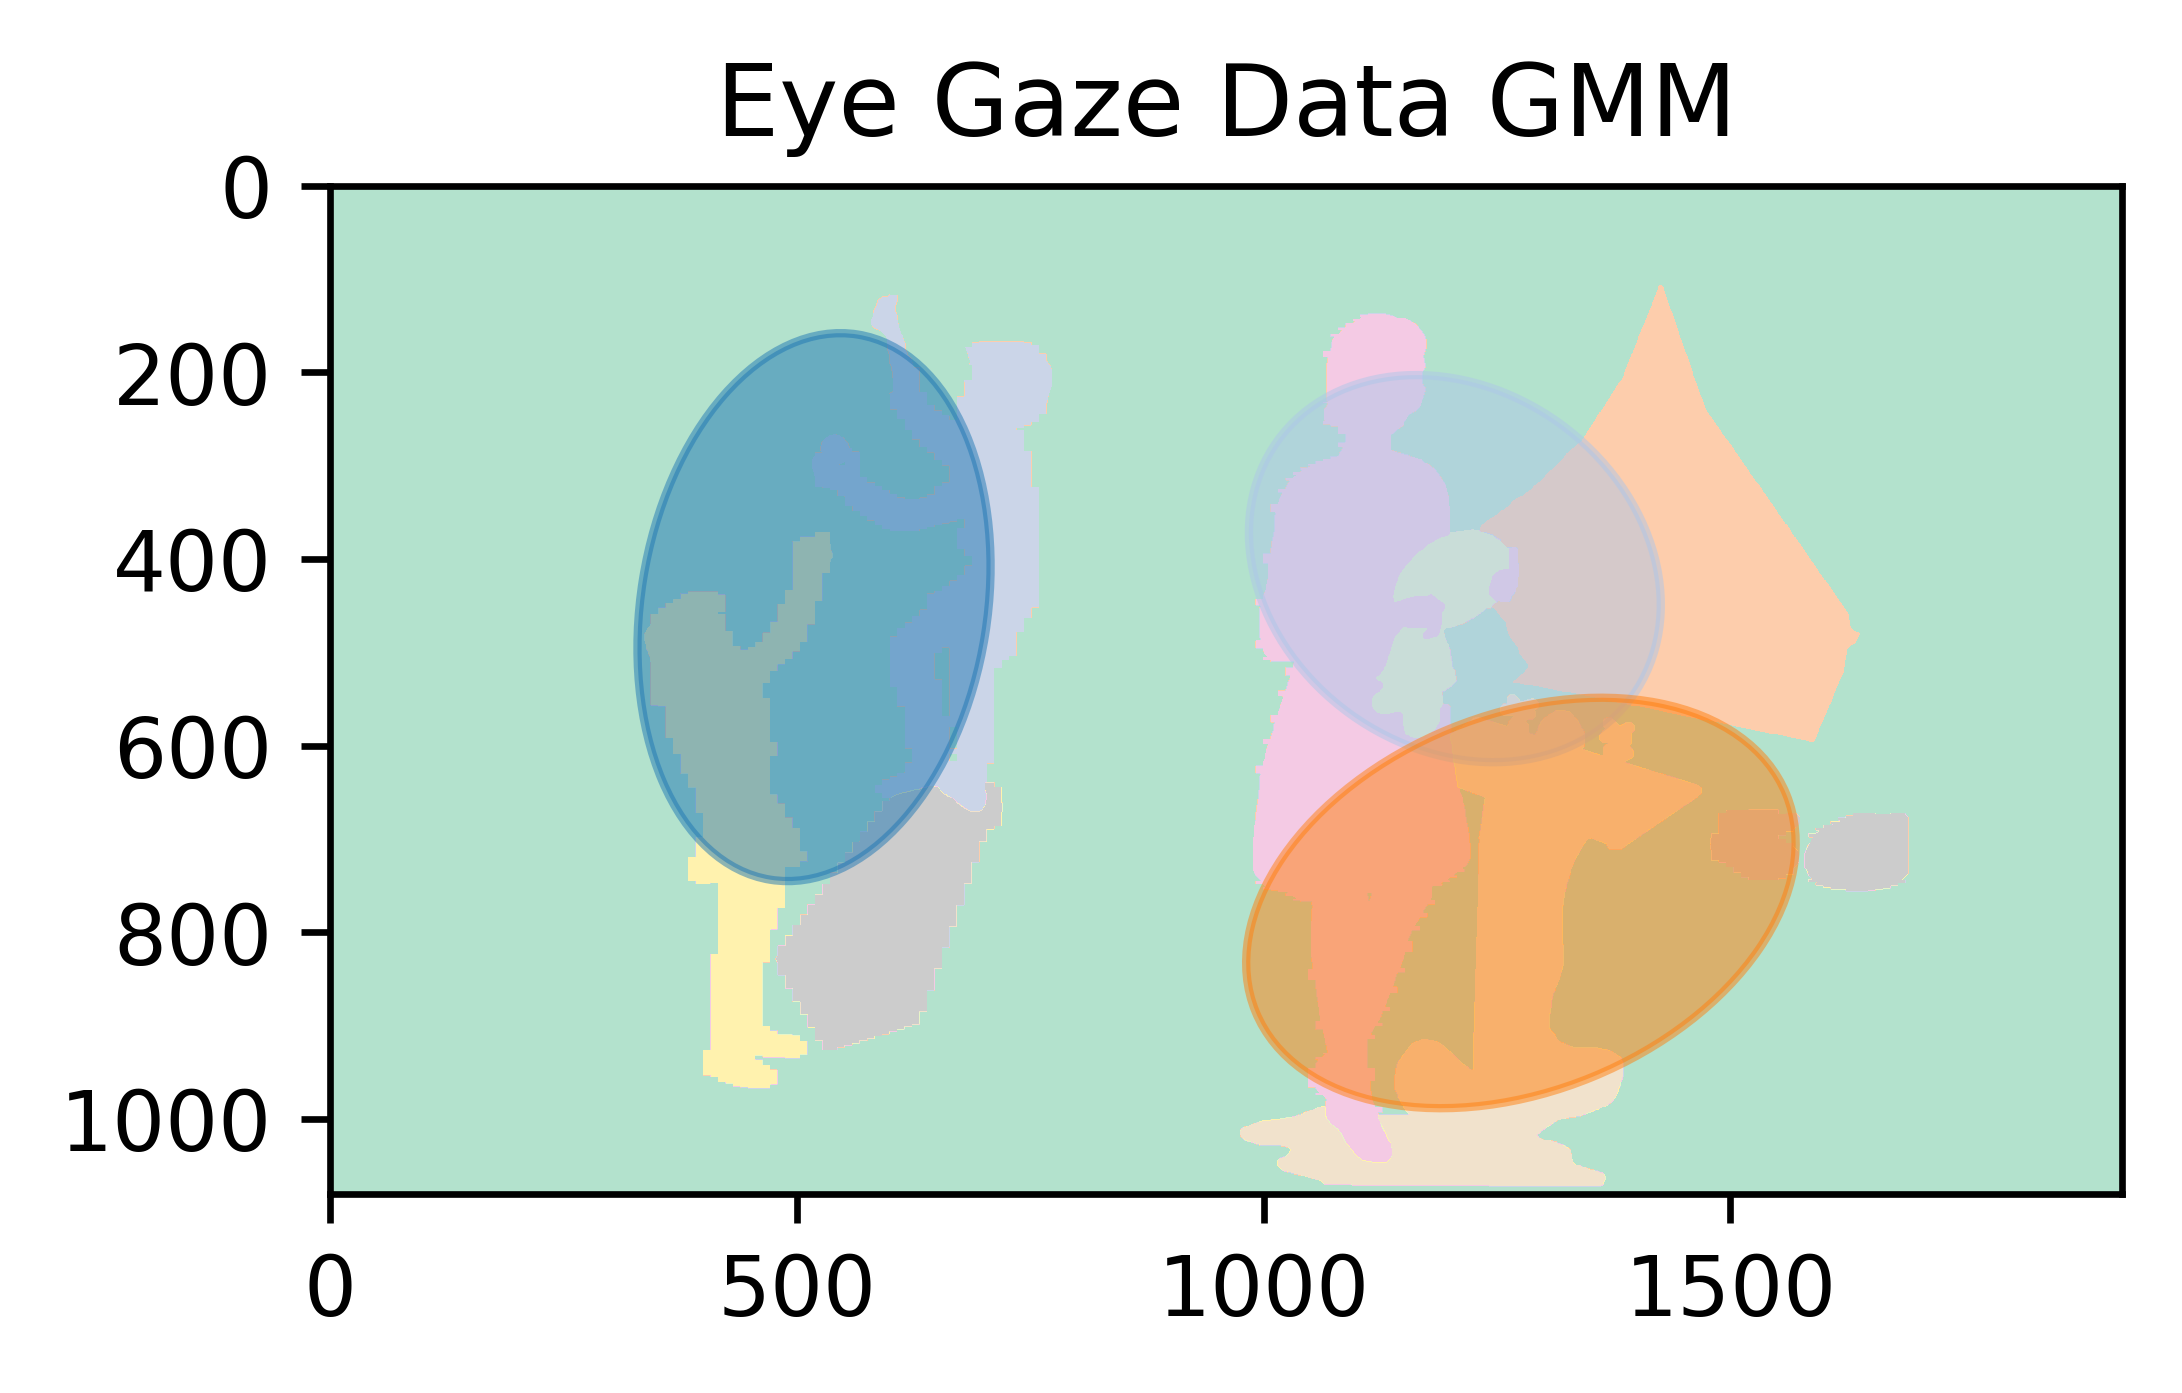

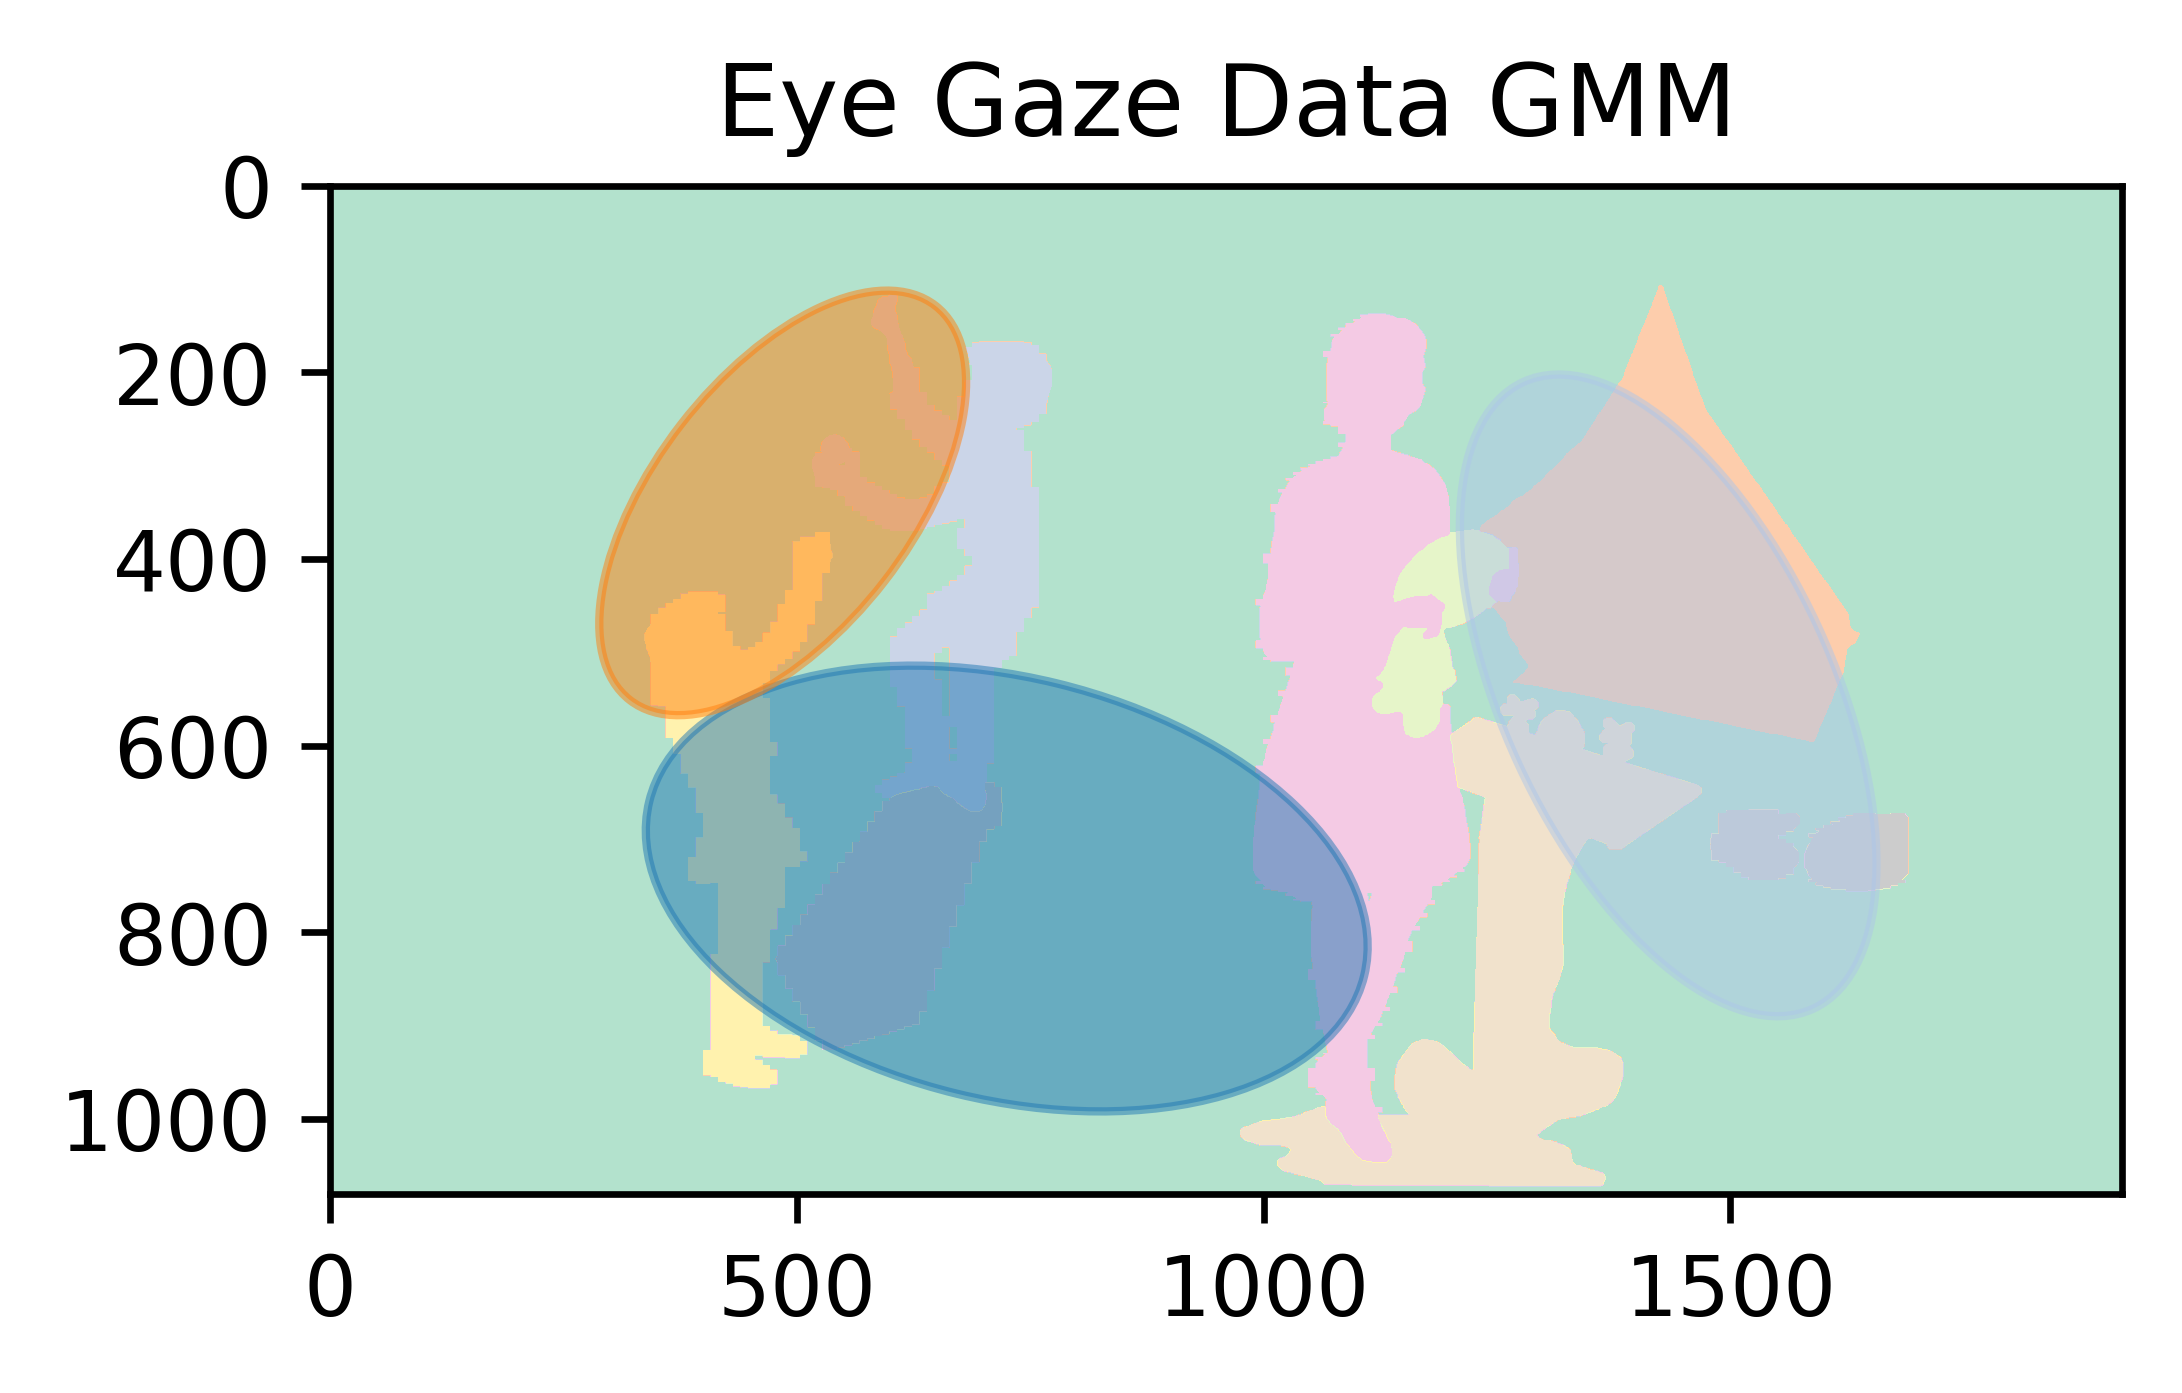

In [56]:
search_parameter_eye_gaze("data/P02_S1_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)
search_parameter_eye_gaze("data/P02_S3_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)
search_parameter_eye_gaze("data/P02_S5 # Partial_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)

Best parameters: {'covariance_type': 'full', 'n_components': 3}
Best parameters: {'covariance_type': 'full', 'n_components': 3}
Best parameters: {'covariance_type': 'full', 'n_components': 3}


{'covariance_type': 'full', 'n_components': 3}

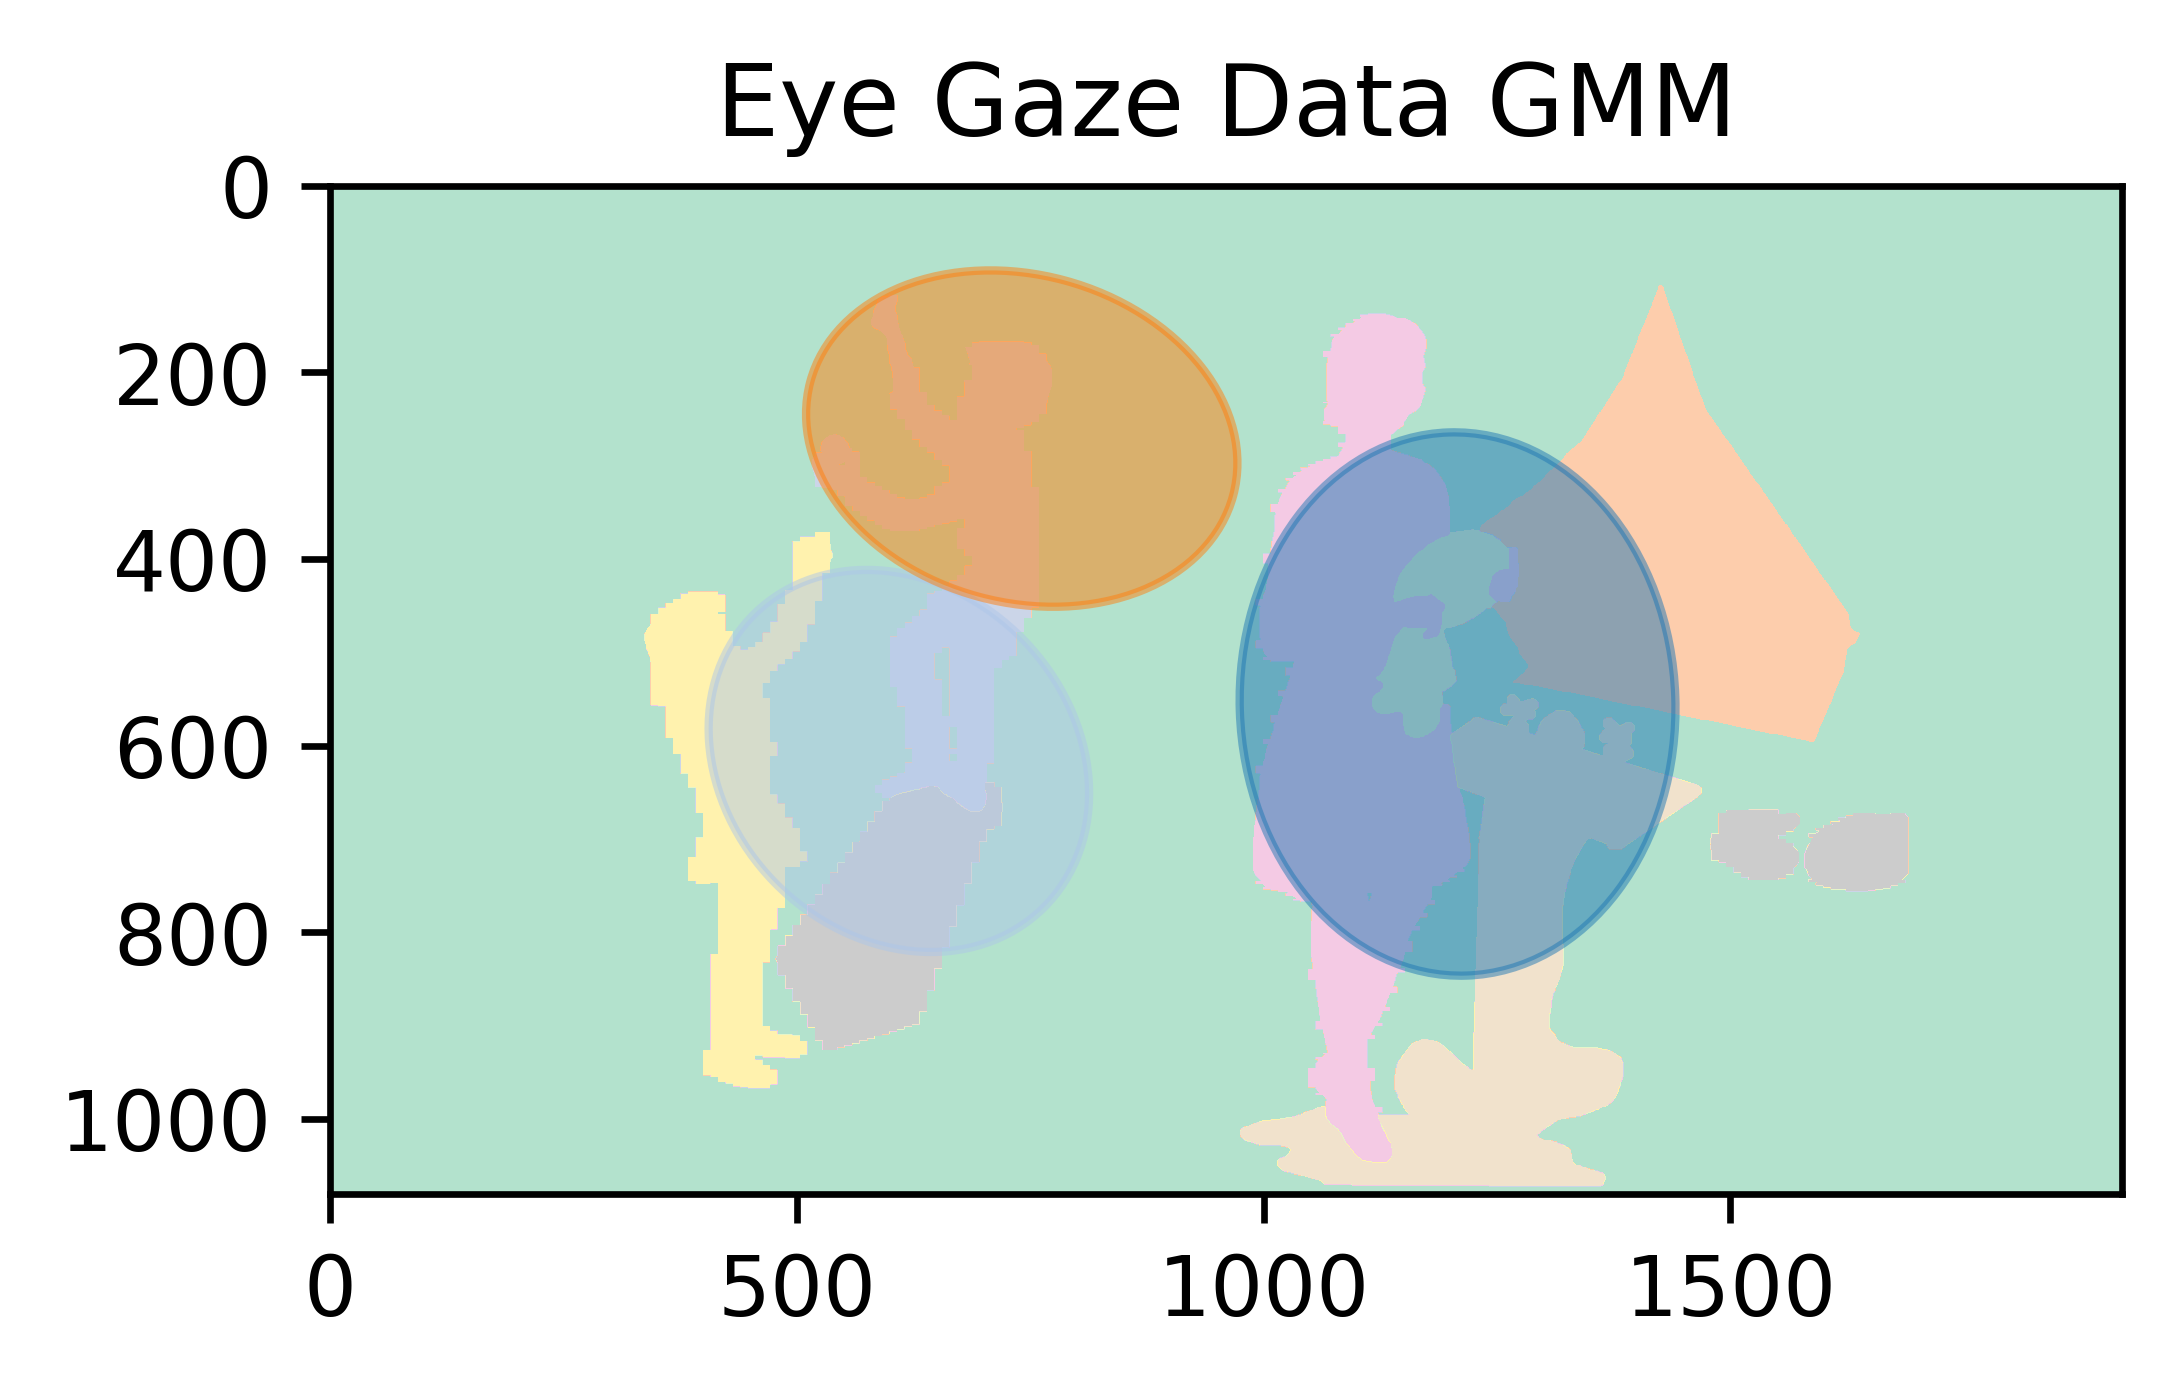

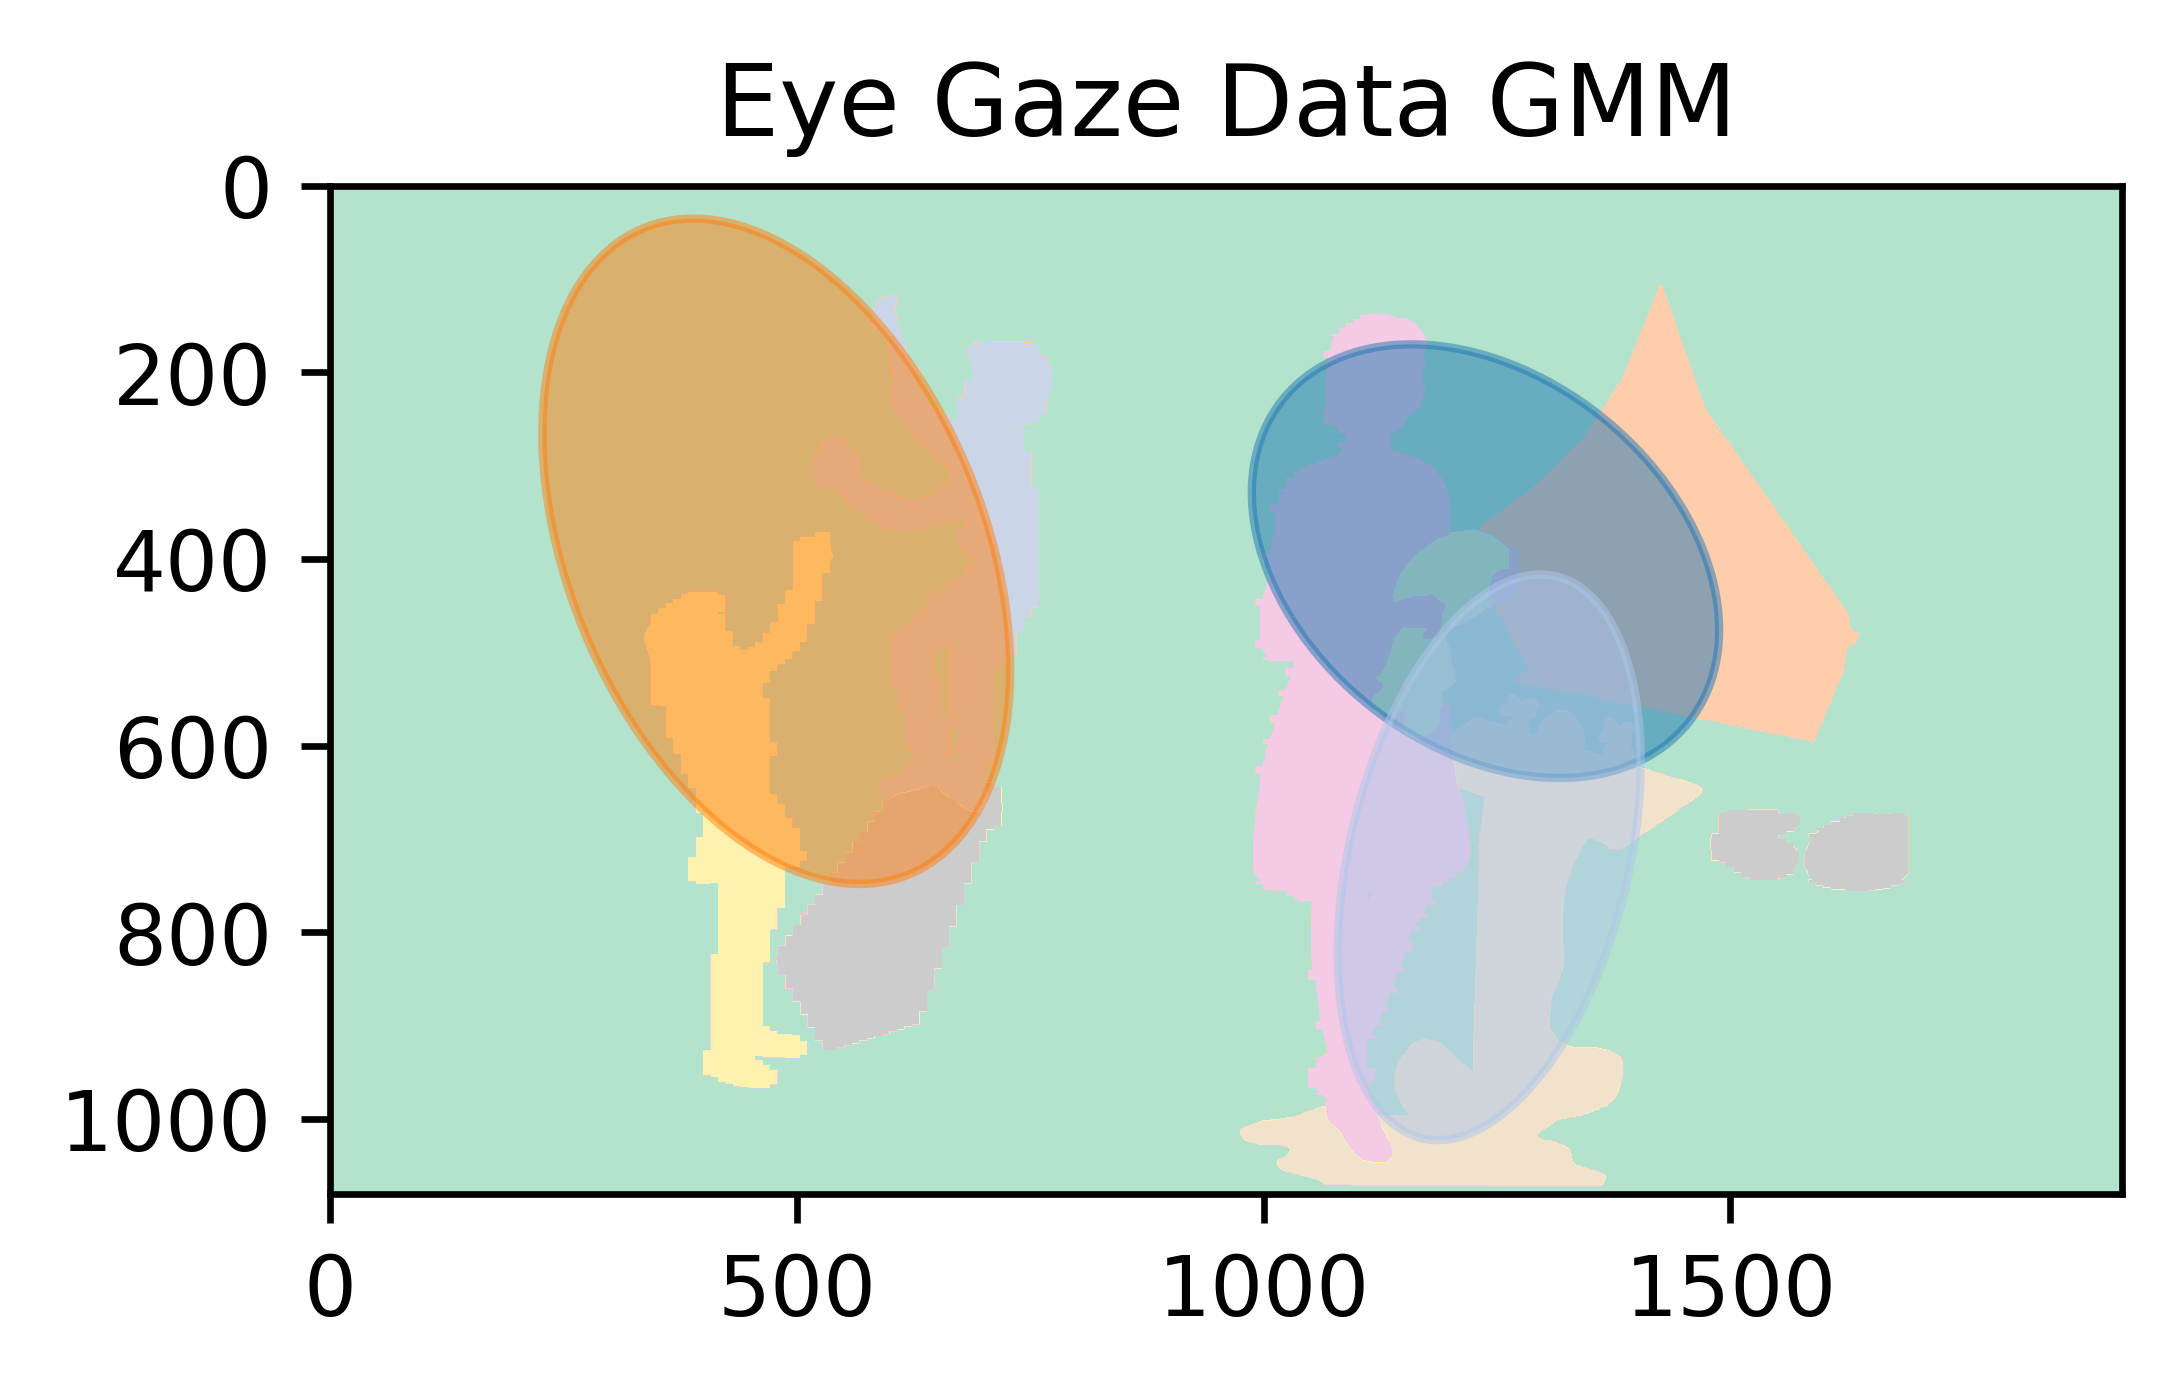

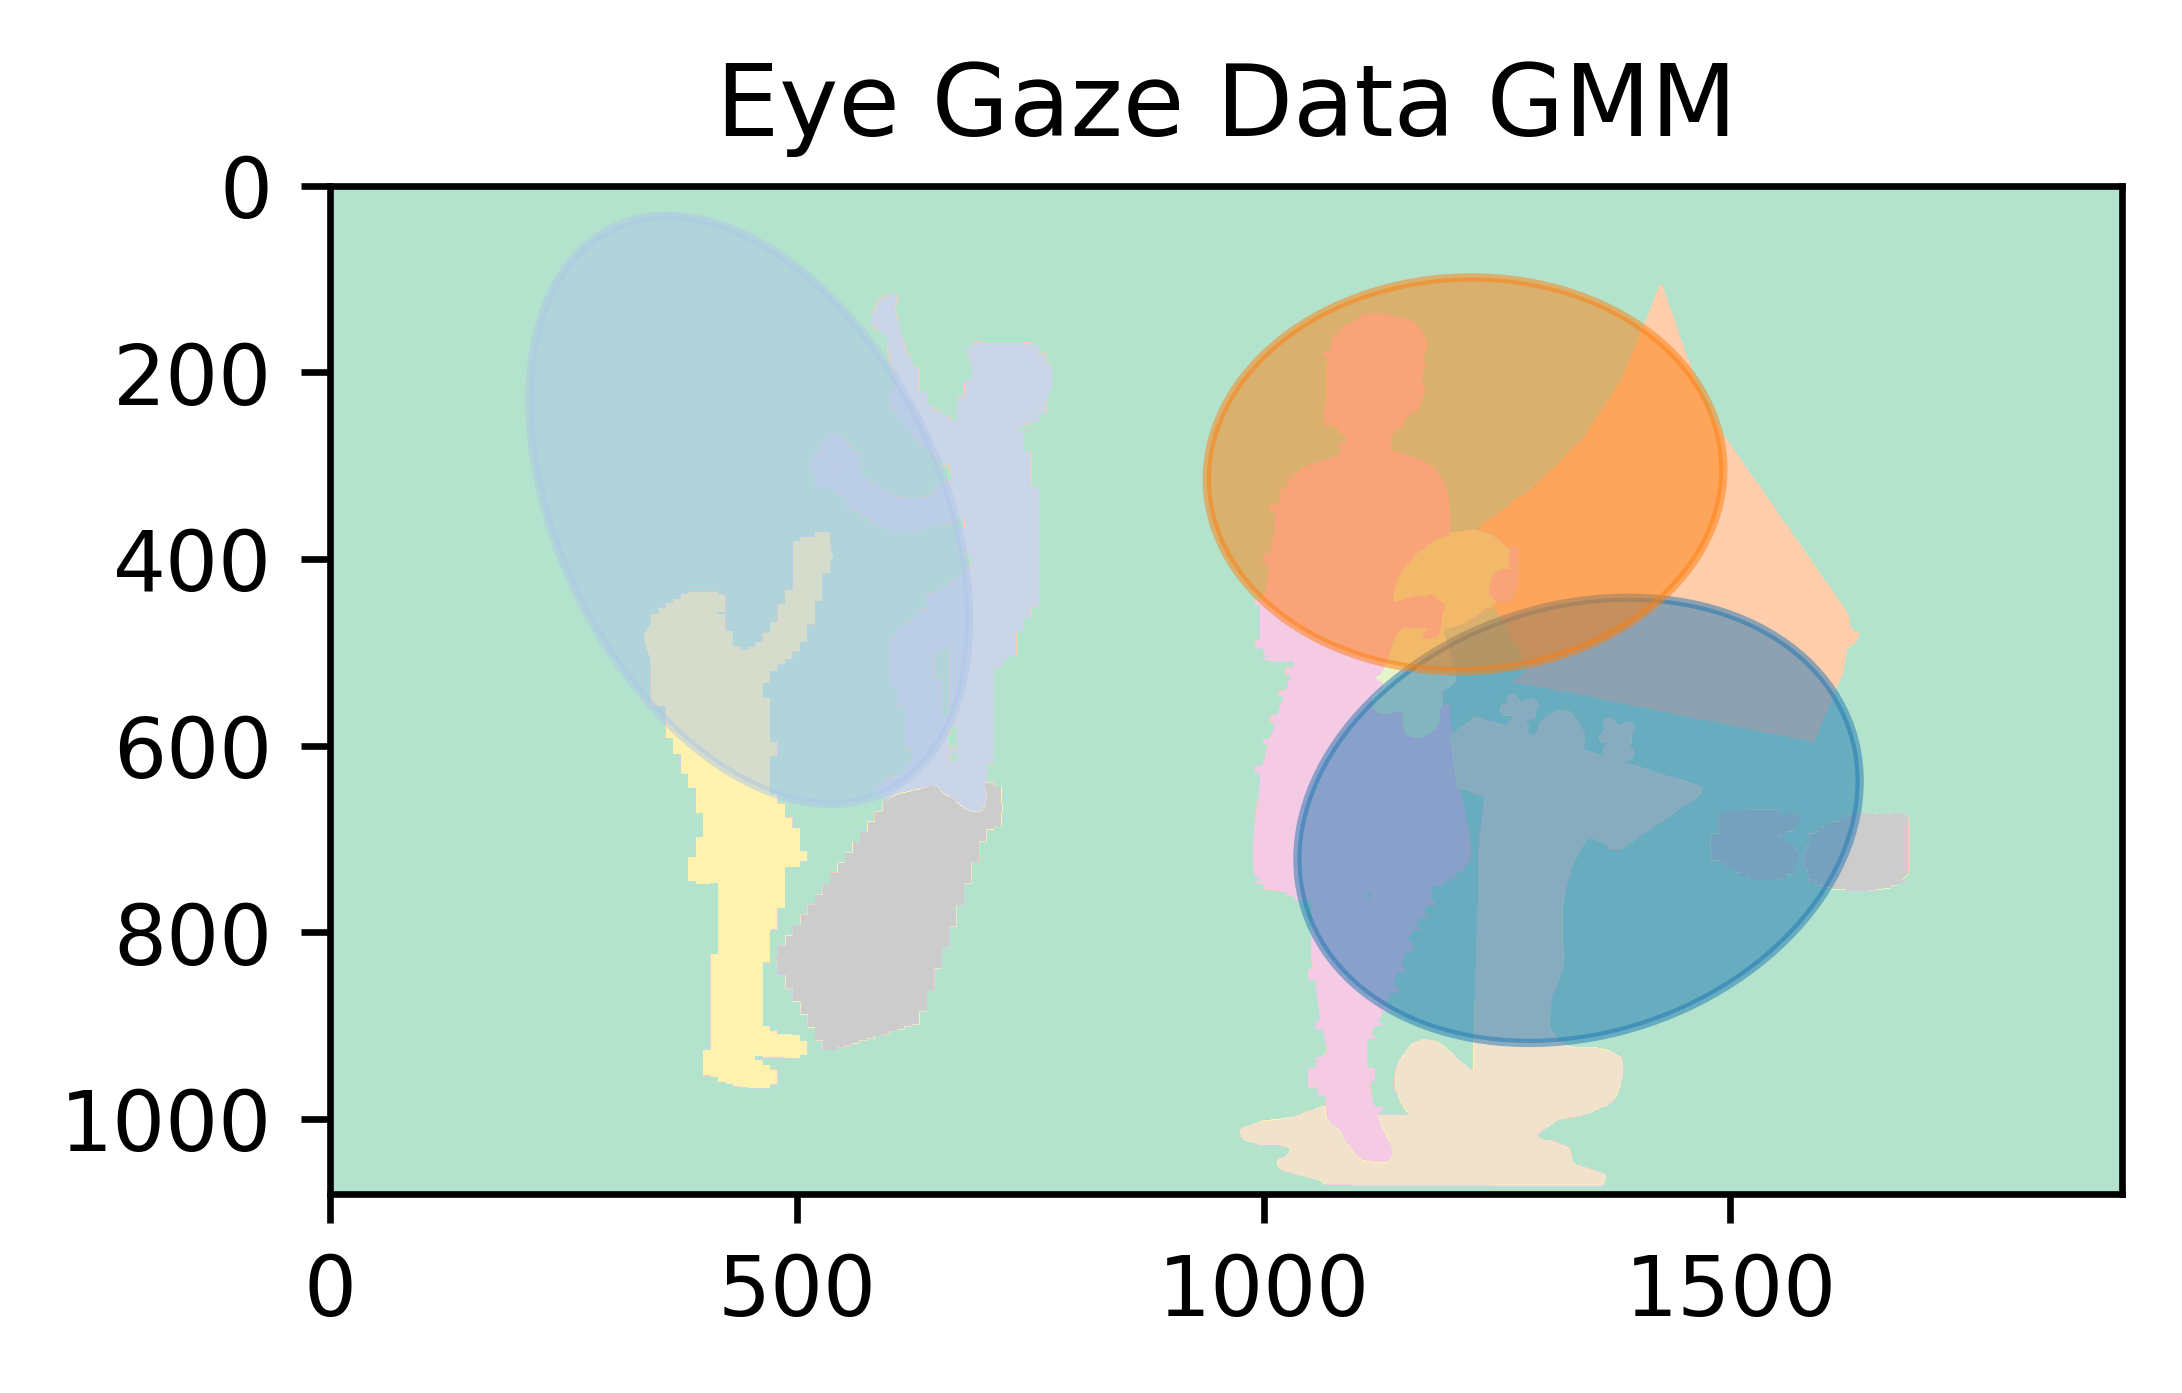

In [54]:
search_parameter_eye_gaze("data/P07_S1_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)
search_parameter_eye_gaze("data/P07_S3_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)
search_parameter_eye_gaze("data/P07_S5_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)